# Simulating Radiation Polarization-Dependent EPR Spectra with MarS

This notebook contains a guide on how to use Mars to simulate EPR spectra when irradiating a sample with light of different polarization types. This guide assumes that you have already read example_1 and understand the general logic behind how MarS works.

\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru\
\
\
The last notebook update: 2026.01.27\
\
Please, if you want to download this notebook to your computer visit https://github.com/ArkadySamsonenkoWork/MarS/tree/main/examples

In [1]:
import sys
import os
import math

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

import mars
from mars import spin_model, spectra_manager, mesher, save_procedures, constants

# 1. Basic Concepts of Radiation Polarization in EPR

In EPR spectroscopy, the polarization of microwave radiation refers to the orientation of its oscillating magnetic field component relative to the static magnetic field and propagation direction of electromagnetic wave. Mars supports three main polarization types:

**Circular polarization** ('+1' or '-1'): The microwave magnetic field rotates clockwise or counterclockwise around the wave direction propagation. The angle between wave direction propagation and static magnetic field is denoted as *theta*
\ 

**Linear polarization** ('lin'): The microwave field oscillates along a fixed direction. The angle between this direction and static magnetic field is denoted as *phi*
\ 

**Unpolarized radiation** ('un'): The radiation is unpolarized. The angle between wave direction propagation and static magnetic field is denoted as *theta*


To work with polarized radiation the "WaveIntensityCalculator" should be used. It takes 4 required positional arguments:

-spin system dimension that can be get from sample

-disordered: True for powder and False for single/many crystal systems

-polarization: polarization type

-theta: the angle between wave direction propagation and static magnetic field

# 2.  Simulating EPR Spectra with Different Radiation Polarizations

Here we consider several examples how spectra can be computed under different polarized microwave radiation

### 2.1 Circularly Polarized Radiation for a Simple Radical (S = 1/2)

We begin by simulating a single organic radical: a spin-1/2 electron with an anisotropic g-tensor, irradiated with positive circular polarization. The microwave propagation direction is perpendicular to the static magnetic field (Voigt geometry).


**Step 1**: Define the Sample

In [2]:
dtype = torch.float64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define g-tensor for a radical
g_tensor = spin_model.Interaction((2.002, 2.005, 2.09), dtype=dtype, device=device)

# Create spin system with one electron
base_spin_system = spin_model.SpinSystem(
    electrons=[0.5],  # Single spin-1/2 electron
    g_tensors=[g_tensor],  # g-tensor
    dtype=dtype,
    device=device
)

# Create sample
sample = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system,
    ham_strain=2e8,  # Hamiltonian strain (broadening) in Hz
    dtype=dtype,
    device=device
)

**Step 2**: Set Up Polarization Intensity Calculator

Now let's create an intensity calculator. Consider the case where the wave is perpendicular to a static magnetic field and has a clockwise polarization.

In [3]:
intensity_calculator = spectra_manager.WaveIntensityCalculator(
    spin_system_dim=sample.spin_system_dim,  # spin_system_dim from a sample
    disordered=sample.mesh.disordered,  # True for powder samples
    polarization='+1',                  # Right-handed (clockwise) circular polarization
    theta=math.pi / 2,                  # Propagation perpendicular to static magnetic field
    device=device,
    dtype=dtype,
)

Instead of sweeping the magnetic field (as in conventional EPR), we fix the field and sweep the microwave frequency-common in high-field EPR spectroscopy:

In [4]:
spectra_creator = spectra_manager.StationaryFreqSpectra(
    field=1.0,  # One Tesla magnetic field
    sample=sample,
    intensity_calculator=intensity_calculator, # If the intensity calculator is not a typical case, a separate copy should be provided.
    harmonic=0,  # 0 for absorption mode, 1 for first derivative
    dtype=dtype,
    device=device
)

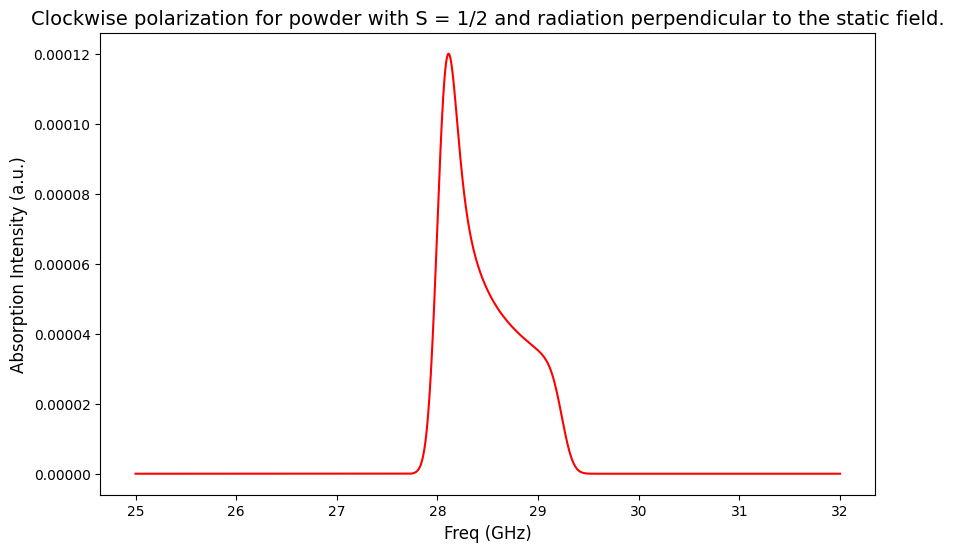

In [5]:
freq = torch.linspace(25.0, 32.0, 2000, device=device, dtype=dtype) * 1e9
spectrum = spectra_creator(sample, freq)

plt.figure(figsize=(10, 6))
plt.plot(freq.cpu().numpy() / 1e9, spectrum.cpu().numpy(), 'r-', linewidth=1.5)
plt.xlabel('Freq (GHz)', fontsize=12)
plt.ylabel('Absorption Intensity (a.u.)', fontsize=12)
plt.title('Clockwise polarization for powder with S = 1/2 and radiation perpendicular to the static field.', fontsize=14)
plt.show()

### 2.2 Polarization-Dependent Transitions in a Co(II) Single-Ion Magnet (S = 3/2


We now simulate a known case of a cobalt(II)-based single-ion magnet (S = 3/2) with strong axial zero-field splitting[ Materials 2019, 12(23), 3865 (DOI: 10.3390/ma12233865)]. This system exhibits EPR transitions whose intensities depend critically on the helicity (circular polarization) of the incident microwave radiation.

In the presence of a large axial zero-field splitting (|D| ≫ μBB), the four spin states split into two Kramers doublets. Within the ground doublet, two primary EPR transitions dominate at low temperatures:

|−3/2⟩ → |−1/2⟩
|+3/2⟩ → |+1/2⟩

Due to angular momentum selection rules, these transitions couple selectively to circularly polarized microwaves:

The |−3/2⟩ → |−1/2⟩ transition (Δm = +1) is driven by positive helicity radiation (σ⁺, right-handed / clockwise polarization).
The |+3/2⟩ → |+1/2⟩ transition (Δm = −1) is driven by negative helicity radiation (σ⁻, left-handed / counter-clockwise polarization).

<img src="energy_diagram.jpg" alt="Drawing" style="width: 800px;"/>


Energy levels of the model system in an applied magnetic field. Black and blue horizontal lines represent levels with negative and positive m, respectively. The arrows denote allowed transitions, the red arrow is the electron paramagnetic resonance (EPR) transition of the excited Kramers doublet, and the green labels indicate transition frequencies [DOI: 10.3390/ma12233865]

In [6]:
dtype = torch.float64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define isotropic g-tensor for Co(II)
g_tensor = spin_model.Interaction((2.02, 2.02, 2.02), dtype=dtype, device=device)

D = constants.unit_converter(-30.0, "cm-1_to_Hz")  # D is negative and equel to -30 cm-1
E = constants.unit_converter(0.0, "cm-1_to_Hz")  # Set E as zero
zero_field_interaction = spin_model.DEInteraction([D, E])

# Create spin system with one electron
base_spin_system = spin_model.SpinSystem(
    electrons=[3/2],  # Single spin-3/2 electron
    g_tensors=[g_tensor],  # g-tensor
    electron_electron=[(0, 0, zero_field_interaction)],  # Zero-Field parameters
    dtype=dtype,
    device=device
)

# Create sample
sample = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system,
    ham_strain=1e11,  # Hamiltonian strain (broadening) in Hz
    dtype=dtype,
    device=device,
    mesh=(100, 100)  # Increase mesh frequency
)

In [7]:
def get_spectrum(polarization: str):
    
    intensity_calculator = spectra_manager.WaveIntensityCalculator(
    spin_system_dim=sample.spin_system_dim,  # spin_system_dim from a sample
    disordered=sample.mesh.disordered,  # True for powder samples
    polarization=polarization,          # Right-handed (clockwise) circular polarization
    theta=0.0,                          # Propagation perpendicular to static magnetic field
    phi=math.pi / 2,                    # Oscillating magnetic field perpendicualr to static field
    temperature=300.0,                    # 300 K temperature
    device=device,
    dtype=dtype,)
    
    spectra_creator = spectra_manager.StationaryFreqSpectra(
    field=10.0,  # Ten Tesla magnetic field
    sample=sample,
    intensity_calculator=intensity_calculator,
    harmonic=0,  # 0 for absorption mode, 1 for first derivative
    dtype=dtype,
    device=device)
    
    freq = torch.linspace(0.0, 3000.0, 6000, device=device, dtype=dtype) * 1e9
    spectrum = spectra_creator(sample, freq)
    spectrum = spectrum / max(spectrum)
    return freq.cpu().numpy(), spectrum.cpu().numpy()

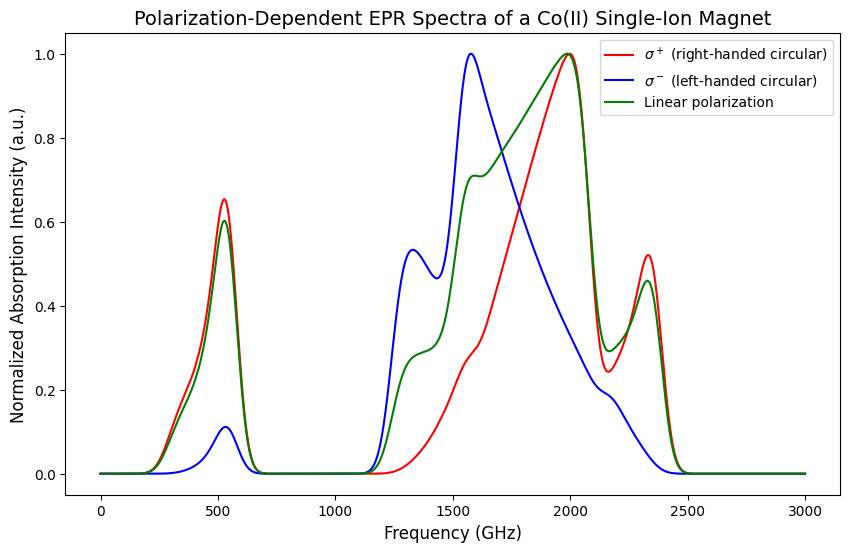

In [8]:
freq, spectrum_plus = get_spectrum("+1")  # σ⁺ (right-handed circular)
freq, spectrum_minus = get_spectrum("-1")  # σ⁻ (left-handed circular)
freq, spectrum_linear = get_spectrum("lin")  # Linear polarization

plt.figure(figsize=(10, 6))
plt.plot(freq / 1e9, spectrum_plus, 'r-', linewidth=1.5, label=r"$\sigma^+$ (right-handed circular)")
plt.plot(freq / 1e9, spectrum_minus, 'b-', linewidth=1.5, label=r"$\sigma^-$ (left-handed circular)")
plt.plot(freq / 1e9, spectrum_linear, 'g-', linewidth=1.5, label="Linear polarization")

plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('Normalized Absorption Intensity (a.u.)', fontsize=12)
plt.title('Polarization-Dependent EPR Spectra of a Co(II) Single-Ion Magnet', fontsize=14)
plt.legend()
plt.show()

This result is in full agreement with the expected theoretical behavior.